# COVID-19 World Overview
> Tracking coronavirus total cases, deaths and new cases by country.

- comments: true
- author: AJ
- categories: [overview, interactive]
- image: images/covid.PNG
- permalink: /covid-overview/
- hide: false

This notebook is update daily to meet current stats. Feel free to comment and give feedback!

In [41]:
#hide
import numpy as np
import pandas as pd
from jinja2 import Template
from IPython.display import HTML
import altair as alt
import matplotlib.pyplot as plt

In [21]:
#hide

# FETCH
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': '/Users/BEBETO/Documents/GitHub/SL_Covid19_Blog/assets/countryContinent.csv',
    'overview': '/Users/BEBETO/Documents/GitHub/SL_Covid19_Blog/assets/overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url, encoding='"ISO-8859-1"')
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }


In [22]:
#hide
mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [25]:
#hide
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]


dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_recoveries = dft_recovered.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_recoveries = dft_recovered.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()

In [30]:
#hide
df_table = (pd.DataFrame(dict(Cases=dfc_cases, Recoveries=dfc_recoveries, Deaths=dfc_deaths, PCases=dfp_cases, 
                              PRecoveries = dfp_recoveries, PDeaths=dfp_deaths))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Deaths, Recoveries'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Recovery Rate'] = (100 * df_table['Recoveries'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.tail()

,Country/Region,Cases,Recoveries,Deaths,PCases,PRecoveries,PDeaths,Cases (+),Deaths (+),Recoveries (+),Fatality Rate,Recovery Rate,Continent
178,Western Sahara,4,0,0,0,0,0,4,0,0,0.0,0.0,Africa
179,Burundi,3,0,0,2,0,0,1,0,0,0.0,0.0,Africa
180,Papua New Guinea,1,0,0,1,0,0,0,0,0,0.0,0.0,Oceania
181,South Sudan,1,0,0,0,0,0,1,0,0,0.0,0.0,Africa
182,Timor-Leste,1,0,0,1,0,0,0,0,0,0.0,0.0,Asia


In [31]:
#hide
# world, china, europe, us
metrics = ['Cases', 'Recoveries', 'Deaths', 'Cases (+)', 'Recoveries (+)', 'Deaths (+)']
s_china = df_table[df_table['Country/Region'].eq('China')][metrics].sum().add_prefix('China ')
s_us = df_table[df_table['Country/Region'].eq('US')][metrics].sum().add_prefix('US ')
s_eu = df_table[df_table['Continent'].eq('Europe')][metrics].sum().add_prefix('EU ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_5ago)}
summary = {**summary, **df_table[metrics].sum(), **s_china, **s_us, **s_eu}
summary

{'updated': Timestamp('2020-04-05 00:00:00'),
 'since': Timestamp('2020-03-31 00:00:00'),
 'Cases': 1272115,
 'Recoveries': 260012,
 'Deaths': 69374,
 'Cases (+)': 414628,
 'Recoveries (+)': 81980,
 'Deaths (+)': 27267,
 'China Cases': 82602,
 'China Recoveries': 77207,
 'China Deaths': 3333,
 'China Cases (+)': 323,
 'China Recoveries (+)': 1001,
 'China Deaths (+)': 24,
 'US Cases': 337072,
 'US Recoveries': 17448,
 'US Deaths': 9619,
 'US Cases (+)': 148900,
 'US Recoveries (+)': 10424,
 'US Deaths (+)': 5746,
 'EU Cases': 636071,
 'EU Recoveries': 122868,
 'EU Deaths': 49113,
 'EU Cases (+)': 190311,
 'EU Recoveries (+)': 56167,
 'EU Deaths (+)': 18900}

In [32]:
#hide
dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,16,0,10,50,4,63,36,8,18,50
Albania,0,0,0,0,0,0,0,0,0,0,...,12,11,15,11,20,16,18,27,29,28
Algeria,0,0,0,0,0,0,0,0,0,0,...,42,45,57,73,132,131,139,185,80,69
Andorra,0,0,0,0,0,0,0,0,0,0,...,43,41,26,36,6,14,38,11,27,35
Angola,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,1,0,0,2,4


In [33]:
#hide_input
template = Template(get_template(paths['overview']))
html = template.render(
    D=summary, table=df_table,  # REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[LAST_DATE_I-50]:dt_cols[LAST_DATE_I]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

In [34]:
#hide
dft_ct_new_cases.reset_index(inplace=True)

In [59]:
#hide
cols = dft_ct_new_cases.keys()
confirmed = dft_ct_new_cases.loc[:, cols[1]:cols[-1]]
dates = confirmed.keys()
world_cases = []
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
germany_cases = []
france_cases = []

for i in dates:
    # case studies
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)
    china_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='China'][i].sum())
    italy_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='Italy'][i].sum())
    us_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='US'][i].sum())
    spain_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='Spain'][i].sum())
    germany_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='Germany'][i].sum())
    france_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='France'][i].sum())

In [ ]:
#hide
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]- data[i-1])
    return d

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
germany_daily_increase = daily_increase(germany_cases)
france_daily_increase = daily_increase(france_cases)

In [84]:
#hide
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [86]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
len(adjusted_dates)

75

# World Coronavirus Cases Overtime

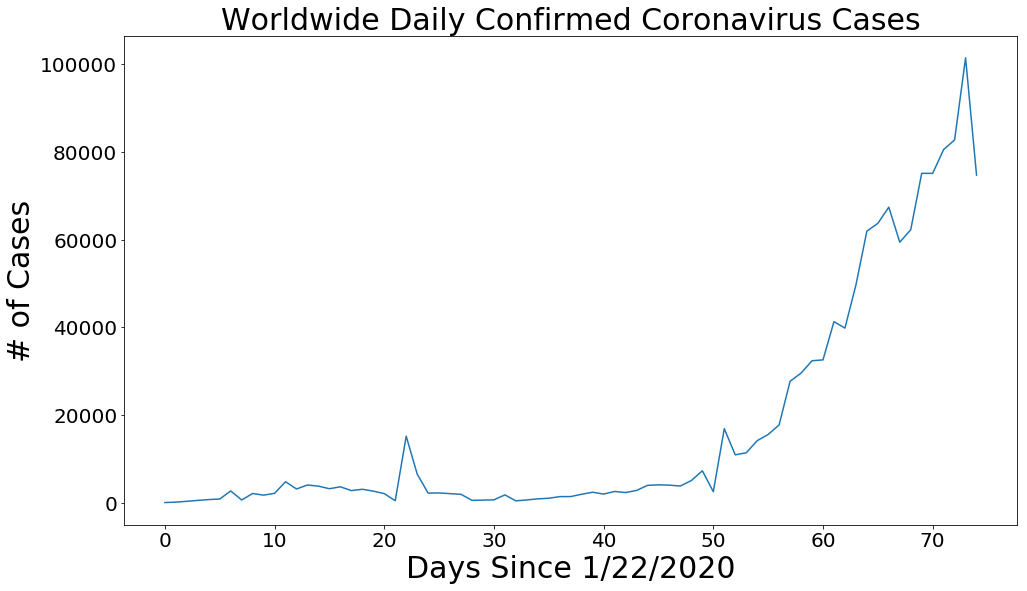

In [87]:
#hide_input
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('Worldwide Daily Confirmed Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

## Daily confirmed cases of Number of Countries

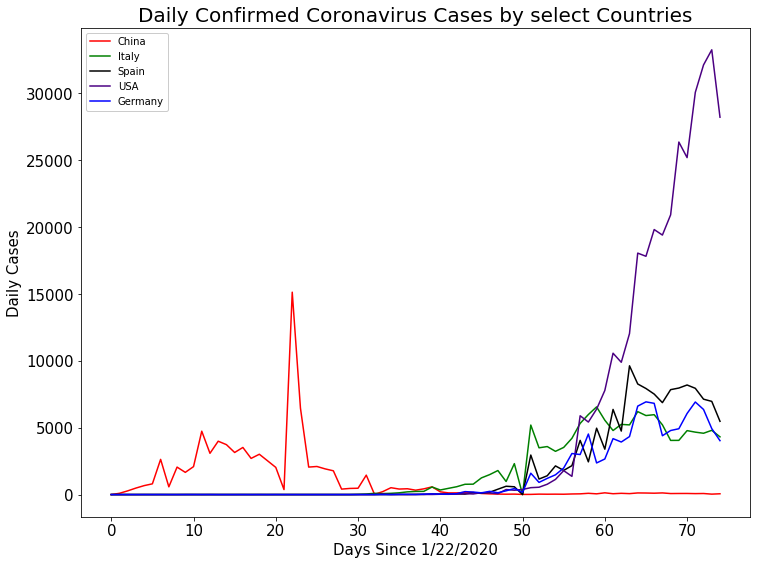

In [88]:
#hide_input
plt.figure(figsize=(12, 9))
plt.plot(adjusted_dates, china_cases, color='red', label='China')
plt.plot(adjusted_dates, italy_cases, color='green', label='Italy')
plt.plot(adjusted_dates, spain_cases, color='black', label='Spain')
plt.plot(adjusted_dates, us_cases, color='indigo', label='USA')
plt.plot(adjusted_dates, germany_cases, color='blue', label='Germany')
plt.legend(framealpha=1, frameon=True)
plt.title('Daily Confirmed Coronavirus Cases by select Countries', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Daily Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

**China has flattened the curve whiles USA, Italy, Germany, Spain are still recording high number of cases
Spain and Germany are closely related in reporting daily cases.